In [1]:
import glob
import json
import os
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage

In [2]:
capacitance_data = {}

with open('recording_id222_rightHanded.json') as file:
    for i, line in enumerate(file):
        json_string = line.rstrip()
        try:
            obj = json.loads(json_string)
        except:
            break
        capacitance_data.update(obj)

In [3]:
len(capacitance_data)

300

## Timestamps

In [4]:
def flatten(l):
    return [item for sublist in l for item in sublist]

### Capacitive data

In [5]:
cap_ts = flatten([list(capacitance_data[cd].keys()) for cd in capacitance_data])
print(f"Total number of capacitance images recorded: {len(cap_ts)}")

Total number of capacitance images recorded: 15501


In [6]:
cap_ts = sorted([int(cp) for cp in cap_ts])

In [7]:
duration = (cap_ts[-1] - cap_ts[0]) / (1000 * 60)
print(f"Duration of the session: {duration:.2f} minutes")

Duration of the session: 21.42 minutes


In [8]:
fps = 1000 / (np.array(cap_ts[1:]) - np.array(cap_ts[:-1]))

In [9]:
print(f"Average frames per second: {fps.mean():.2f}")

Average frames per second: 12.70


In [10]:
fps = pd.Series(fps)

In [11]:
fps.describe()

count    15500.000000
mean        12.702980
std          1.381617
min          0.156495
25%         12.195122
50%         12.820513
75%         13.513514
max         15.384615
dtype: float64

<AxesSubplot: >

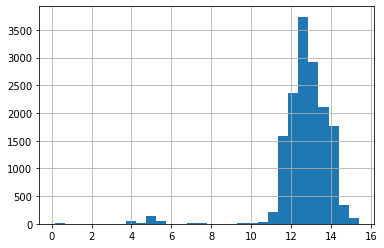

In [12]:
fps.hist(bins=30)

### Leap Motion data

In [4]:
leap_motion_data = {}
NUM_FILES = 92
for file_nb in range(NUM_FILES):
    with open(f'data/joint_positions_id1_num{file_nb}.json') as file:
        obj = json.load(file)
        leap_motion_data.update(obj)

In [6]:
lm_ts = leap_motion_data.keys()
print(f"Total number of leap motion recordings: {len(lm_ts)}")

Total number of leap motion recordings: 51792


In [7]:
lm_ts = sorted([int(cp) for cp in lm_ts])

In [8]:
duration = (lm_ts[-1] - lm_ts[0]) / (1000 * 60)
print(f"Duration of the session: {duration:.2f} minutes")

Duration of the session: 15.13 minutes


In [9]:
fps = 1000 / (np.array(lm_ts[1:]) - np.array(lm_ts[:-1]))

In [10]:
print(f"Average frames per second: {fps.mean():.2f}")

Average frames per second: 133.99


In [11]:
fps = pd.Series(fps)

In [12]:
fps.describe()

count    51791.000000
mean       133.994458
std        146.708829
min          0.066680
25%         83.333333
50%        100.000000
75%        111.111111
max       1000.000000
dtype: float64

<AxesSubplot:>

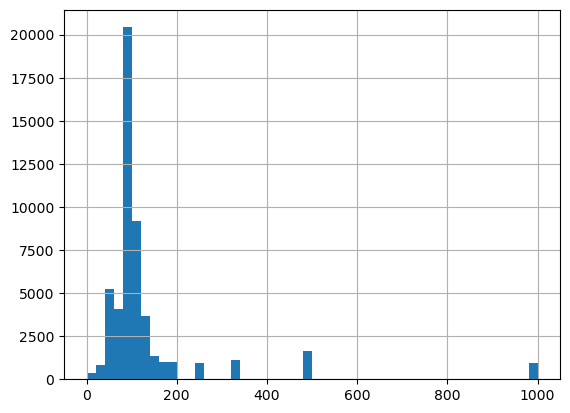

In [13]:
fps.hist(bins=50)

### RealSense data

In [22]:
# realsense_data = {}
rs_ts = []
NUM_FILES = 31  #TODO
for file_nb in range(2, NUM_FILES):
    # print(file_nb)
    with open(f'data/realsense_id1_num{file_nb}.json') as file:
        obj = json.load(file)
        rs_ts.extend(obj.keys())
        # realsense_data.update(obj)

In [33]:
print(f"Total number of RealSense Frames: {len(rs_ts)}")

Total number of RealSense Frames: 514


In [34]:
rs_ts = sorted([int(cp) for cp in rs_ts])

In [35]:
duration = (rs_ts[-1] - rs_ts[0]) / (1000 * 60)
print(f"Duration of the session: {duration:.2f} minutes")

Duration of the session: 14.19 minutes


In [45]:
gaps = (np.array(rs_ts[1:]) - np.array(rs_ts[:-1]))

In [48]:
fps = 1000 / gaps

In [49]:
gaps = pd.Series(gaps)

In [51]:
gaps.describe()

count      513.000000
mean      1659.814815
std       6750.683466
min          7.000000
25%         55.000000
50%         66.000000
75%         74.000000
max      49545.000000
dtype: float64

<AxesSubplot:>

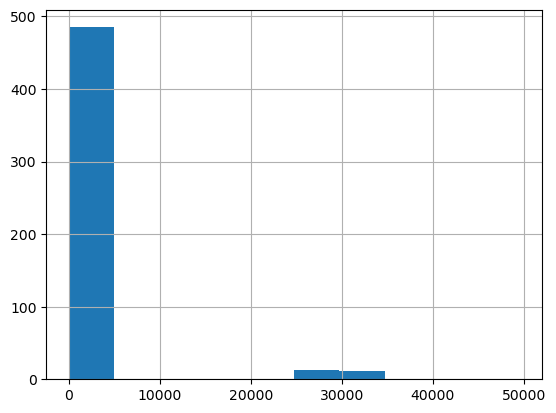

In [57]:
gaps.hist(bins=10)

<AxesSubplot:>

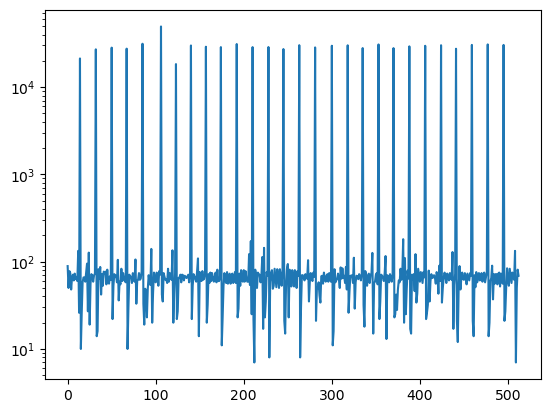

In [66]:
gaps.plot.line(x="frame", logy=True)

In [50]:
print(f"Average frames per second: {fps.mean():.2f}")

Average frames per second: 19.96


In [38]:
fps = pd.Series(fps)

In [39]:
fps.describe()

count    513.000000
mean      19.958362
std       17.482790
min        0.020184
25%       13.513514
50%       15.151515
75%       18.181818
max      142.857143
dtype: float64

<AxesSubplot:>

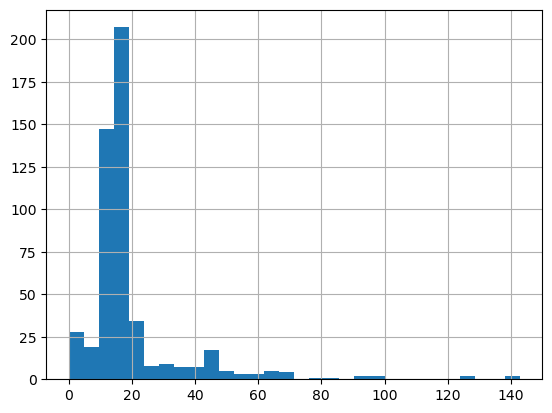

In [32]:
fps.hist(bins=30)

## Capacitive data processing

In [13]:
flat_cap_data = [k.split(".")[:-1] + [v[0]] for k, v in pd.json_normalize(capacitance_data).to_dict().items()]
flat_cap_data = [w1 + [w2[-1]] for w1, w2 in zip(flat_cap_data[::2], flat_cap_data[1::2])]
flat_cap_data = sorted(flat_cap_data, key=lambda w: w[1])

In [14]:
len(flat_cap_data)

15501

In [15]:
def preprocess(img):
    img[img < 0] = 0
    return img

In [16]:
def preprocess_cap_data(imgs):
    prep_flat_cap_data = imgs.copy()
    for pfcp in prep_flat_cap_data:
        pfcp[-1] = np.array(pfcp[-1])
        pfcp[-1] = preprocess(pfcp[-1])
    prep_flat_cap_data = [pfcp for pfcp in prep_flat_cap_data if pfcp[-1].sum() > 0]
    return prep_flat_cap_data

In [17]:
prep_flat_cap_data = preprocess_cap_data(flat_cap_data)

In [18]:
len(prep_flat_cap_data)

15452

In [19]:
df = pd.DataFrame (prep_flat_cap_data, columns = ['digit', 'timestamp', 'pen_pos', 'cap_img'])
df

,digit,timestamp,pen_pos,cap_img
0,7lf0,1551101425307,"[21, 21]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,7lf0,1551101425377,"[21, 21]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2,7lf0,1551101425447,"[21, 21]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,7lf0,1551101425520,"[21, 21]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,7lf0,1551101425596,"[21, 21]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
...,...,...,...,...
15447,2lg0,1551102710116,"[896, 1066]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
15448,2lg0,1551102710200,"[896, 1066]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
15449,2lg0,1551102710284,"[896, 1066]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
15450,2lg0,1551102710370,"[896, 1066]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [20]:
df["cap_img_2d"]=df["cap_img"].apply(compute_img)

NameError: name 'compute_img' is not defined

In [21]:
df["com"] = df["cap_img_2d"].apply(ndimage.center_of_mass)

KeyError: 'cap_img_2d'

In [ ]:
def get_2d_coms(coms):
    coms_2d = [0] * 49 * 37
    coms_2d = np.reshape(coms_2d, (37, 49))
    coms_bin = set([(int(com[0]),int(com[1]) )for com in coms])
    for com in coms_bin:
        coms_2d[com[0]][com[1]]=1
    return coms_2d

In [ ]:
df["com"] = df["cap_img_2d"].apply(ndimage.center_of_mass)

array([[<AxesSubplot: title={'center': 'timestamp'}>]], dtype=object)

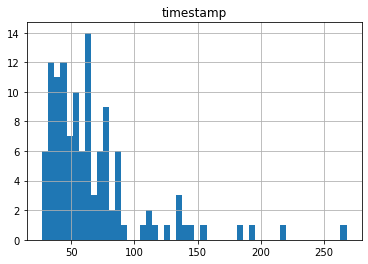

In [13]:
df.groupby("digit").count()[["timestamp"]].hist(bins=50)

In [14]:
df.groupby("digit").count()[["timestamp"]].describe()

,timestamp
count,120.00000
mean,67.05000
std,39.43612
min,27.00000
25%,42.00000
50%,57.00000
75%,78.00000
max,268.00000


## Capacitive data viz

In [22]:
def display(cap_img):
    new_cap_img = [0] * 49 * 37
    for y in range(49):
        for x in range(37):
            val = cap_img[y * 37 + x]
            new_cap_img[(37 - x - 1) * 49 + y] = val
    cap_img_2d = np.reshape(new_cap_img, (37, 49))
    plt.imshow(cap_img_2d, cmap='hot', interpolation='nearest')
    # heatmap = plt.pcolor(cap_img)
    # plt.colorbar(heatmap)
    plt.show()

In [23]:
def generate_video(img, video_name):
    for i in range(len(img)):
        plt.imshow(img[i], cmap='hot', interpolation='nearest')
        plt.savefig("video_imgs" + "/file%02d.png" % i)

    os.chdir("video_imgs")
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        f'{video_name}.mp4'
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)
    os.chdir("..")

In [24]:
def compute_img(cap_img):
    new_cap_img = [0] * 49 * 37
    for y in range(49):
        for x in range(37):
            val = cap_img[y * 37 + x]
            new_cap_img[(37 - x - 1) * 49 + y] = val
    cap_img_2d = np.reshape(new_cap_img, (37, 49))
    return cap_img_2d

0mf0


FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

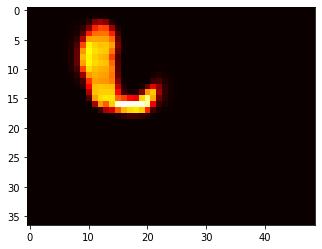

In [18]:
for name, group in df.groupby("digit")[["cap_img", "digit"]]:
    print(name)
    imgs = []
    for ci in group["cap_img"].to_list():
        imgs.append(compute_img(ci))
    generate_video(imgs, name)


In [68]:
def f7(seq):
    seen = set()
    return [x for x in seq if not (x in seen or seen.add(x))]

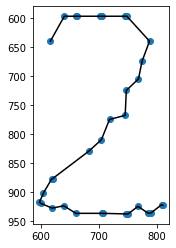

In [69]:
zero=df.groupby("digit")["pen_pos"].apply(list).to_dict()["2mg0"]
zero=f7([tuple(z) for z in zero])[1:]
fig = plt.figure()
plt.scatter(x=[z[0] for z in zero], y=[z[1] for z in zero])
plt.plot([z[0] for z in zero], [z[1] for z in zero], "k")
ax = plt.gca()
ax.invert_yaxis()
ax.set_aspect('equal', adjustable='box')
# plt.show()
fig.canvas.draw()


In [21]:
data = np.frombuffer(fig.canvas.tostring_rgb, dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

TypeError: a bytes-like object is required, not 'method'

In [25]:
480*640*3

921600

In [16]:
fig.canvas.get_width_height()[::-1] + (3,)

(480, 640, 3)

In [22]:
len(data)

355593

0mf0


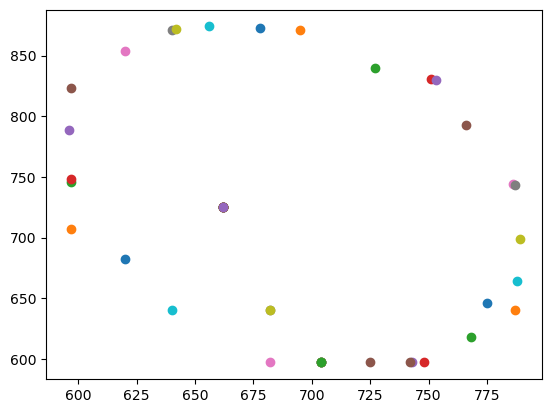



0mf1


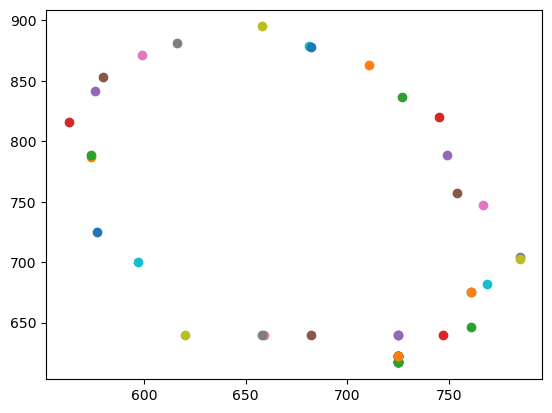



0mf2


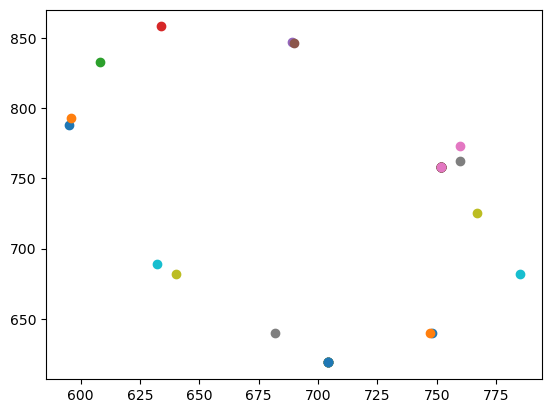



0mg0


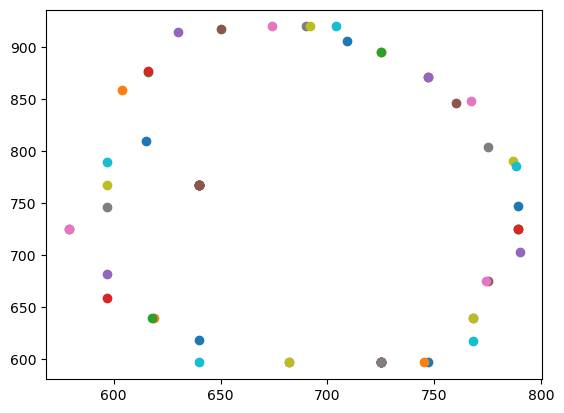



0mg1


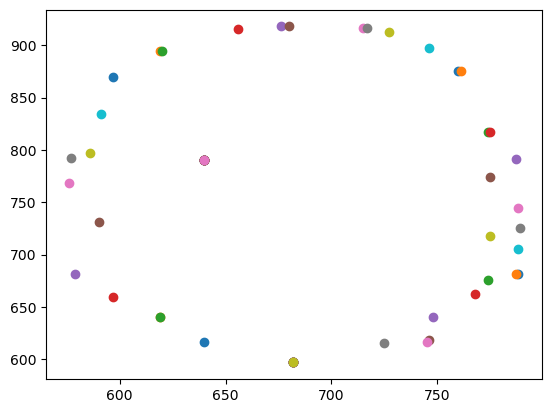



0mg2


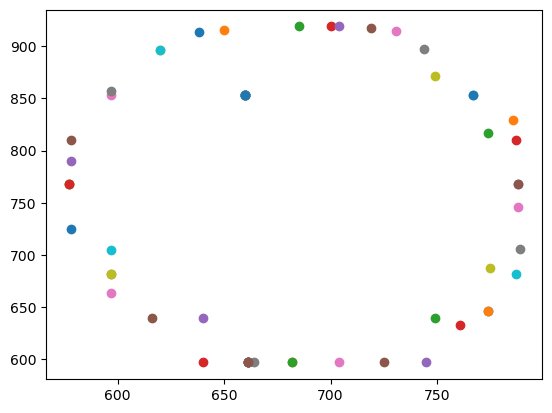



0sf0


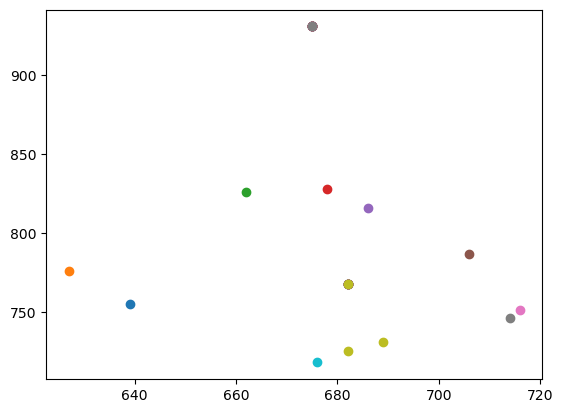



0sf1


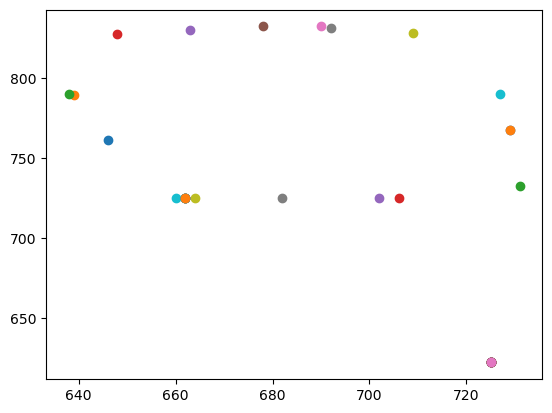



0sf2


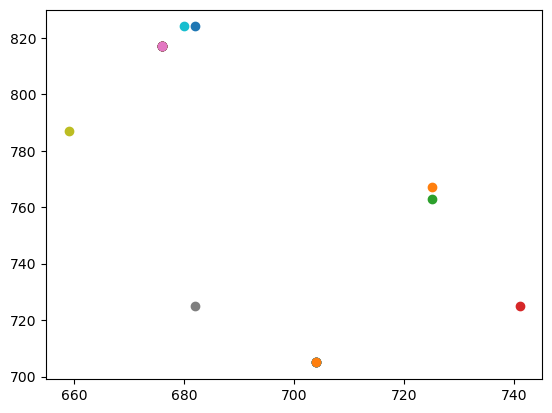



0sg0


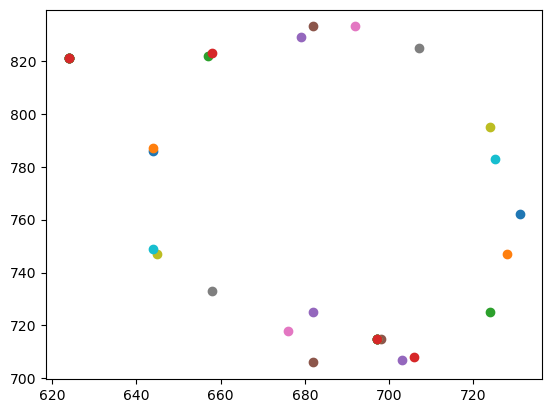



0sg1


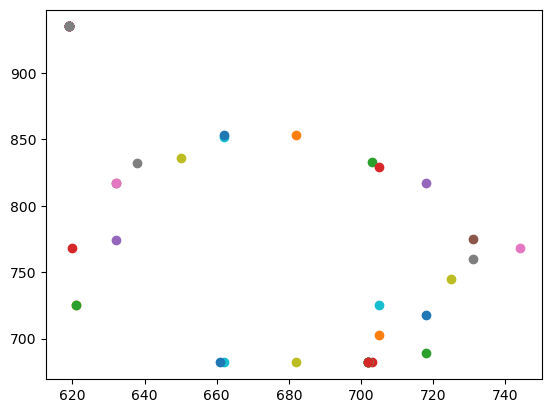



0sg2


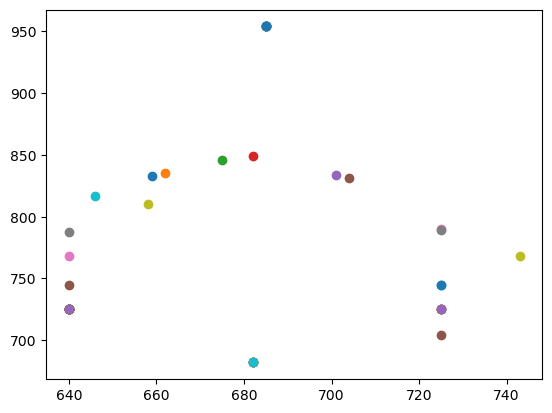



1mf0


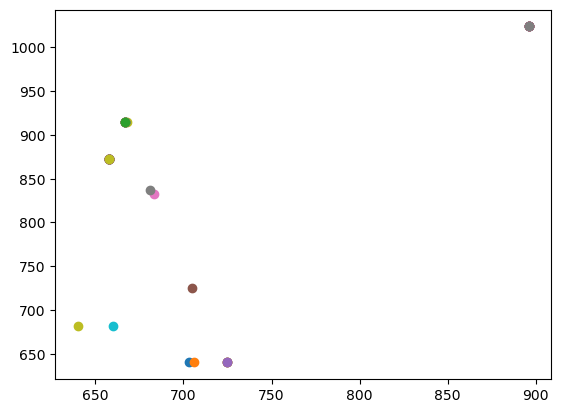



1mf1


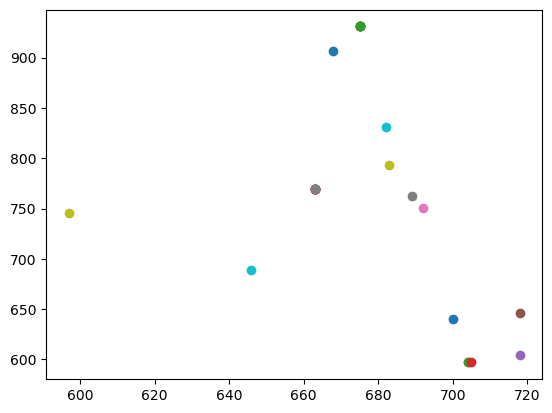



1mf2


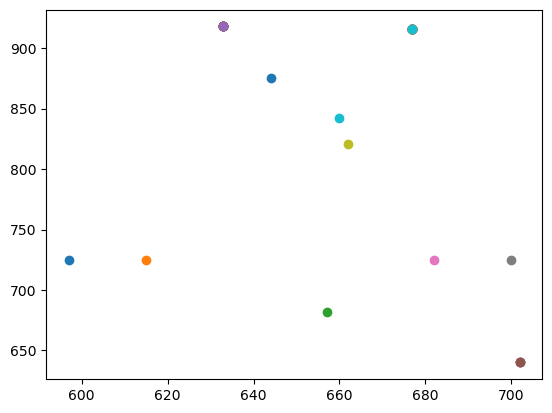



1mg0


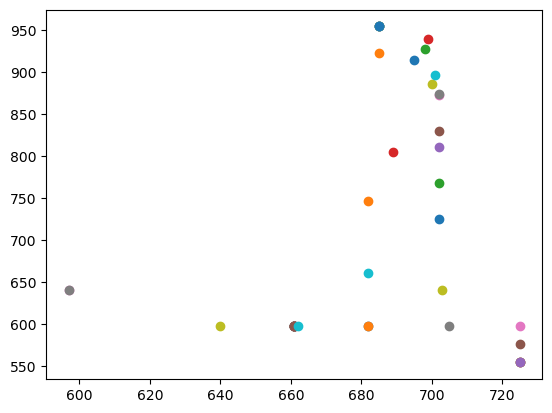



1mg1


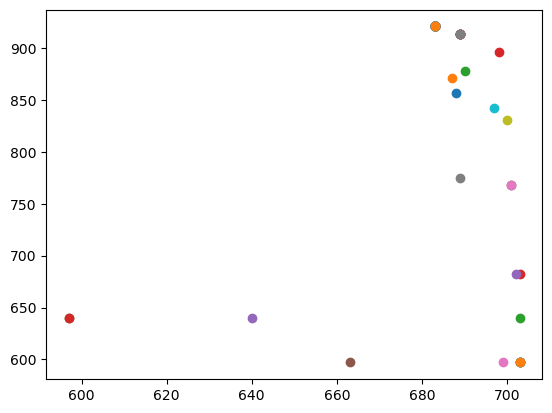



1mg2


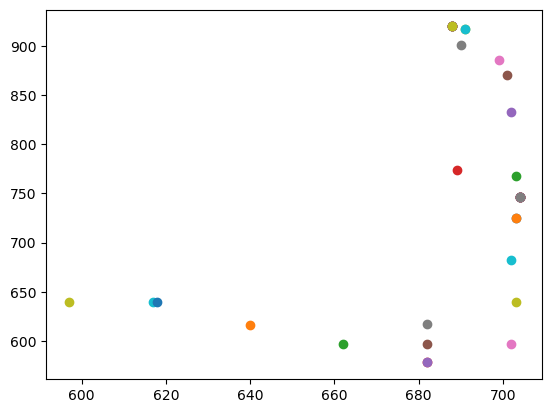



1sf0


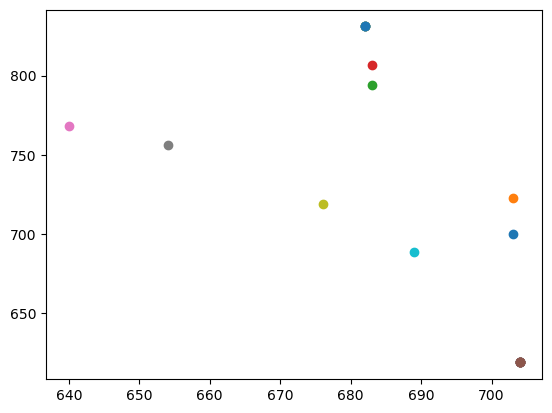



1sf1


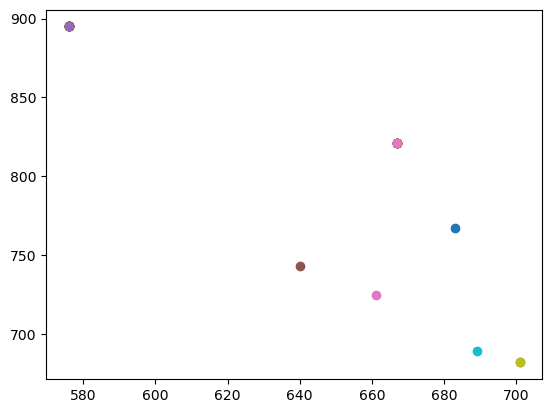



1sf2


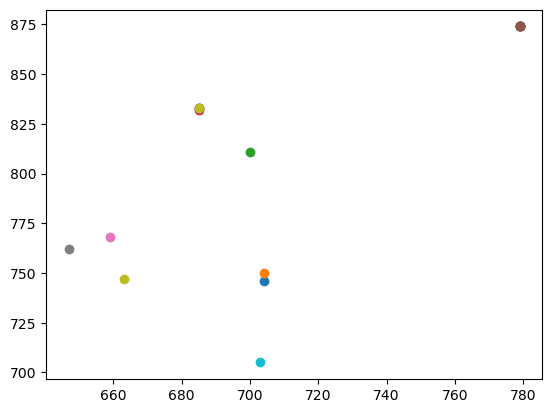



1sg0


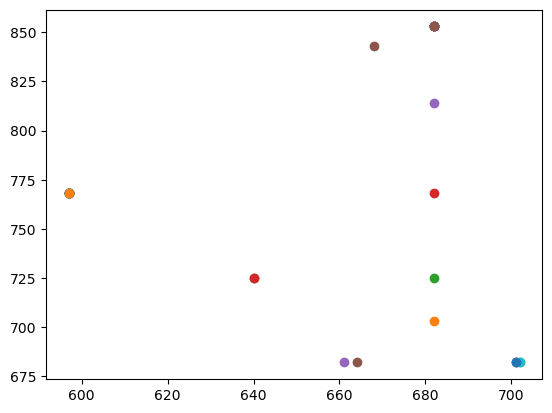



1sg1


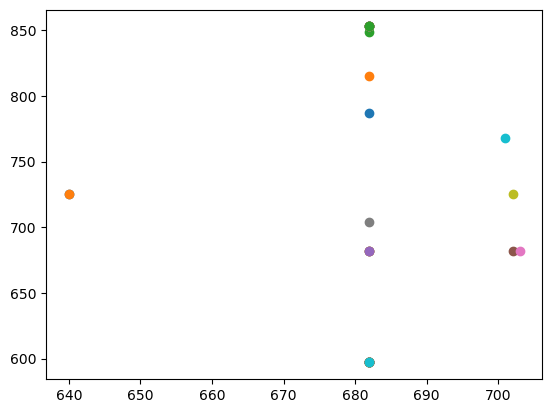



1sg2


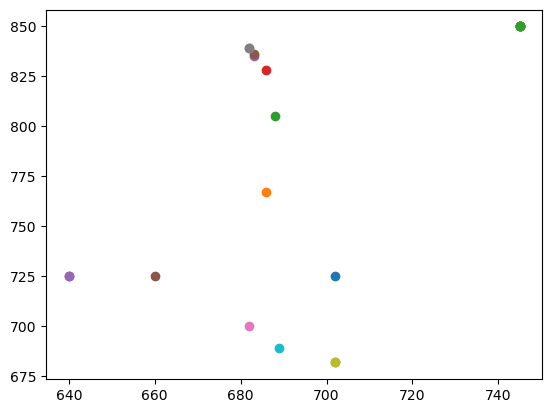



2mf0


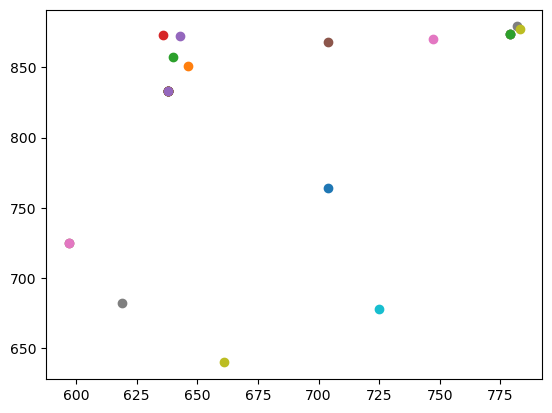



2mf1


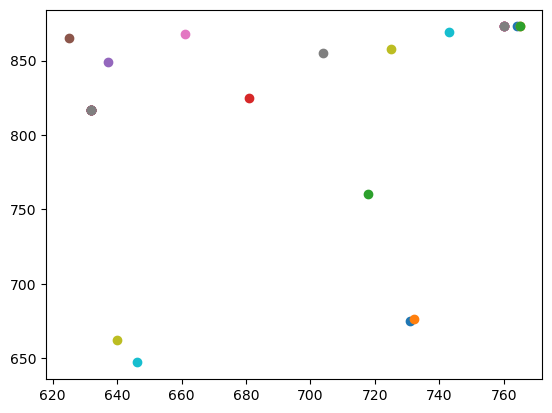



2mf2


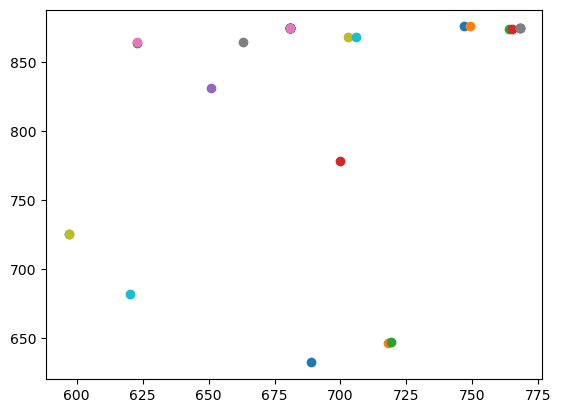



2mg0


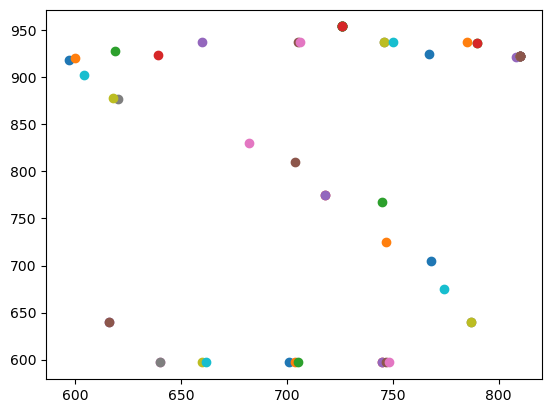



2mg1


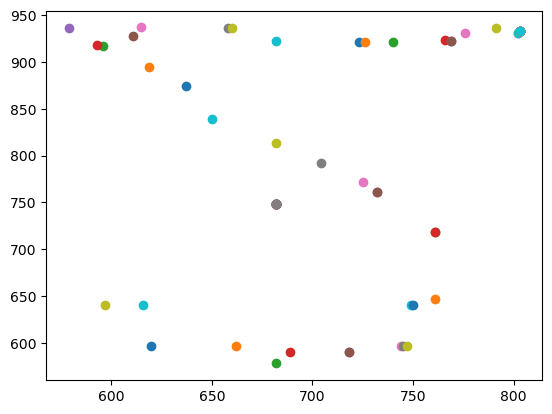



2mg2


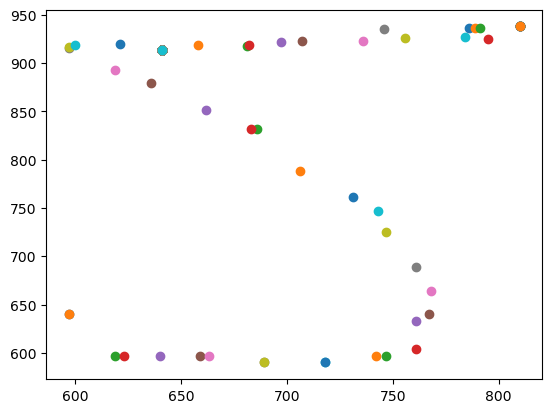



2sf0


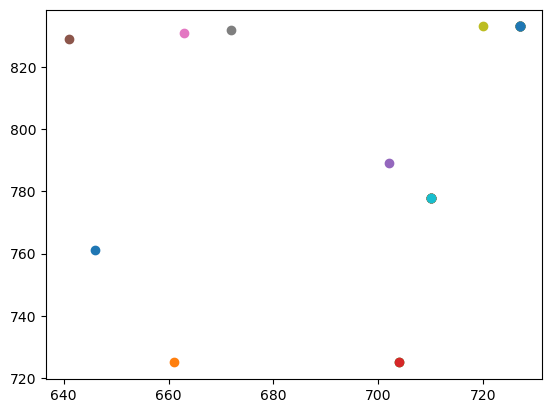



2sf1


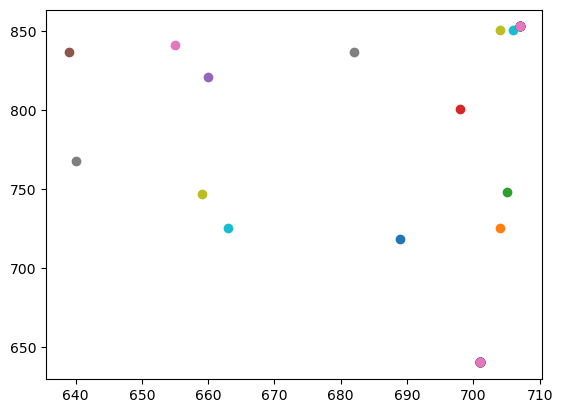



2sf2


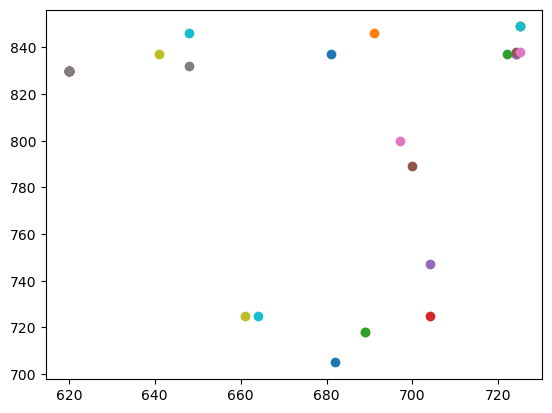



2sg0


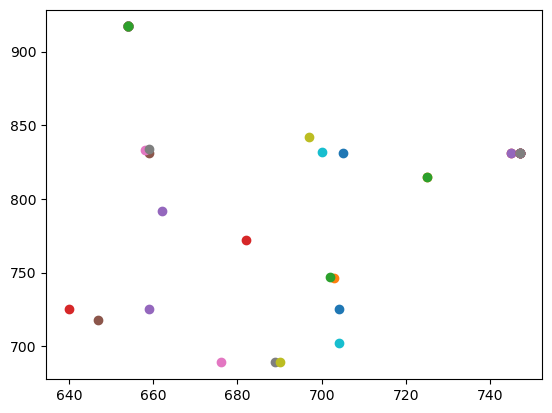



2sg1


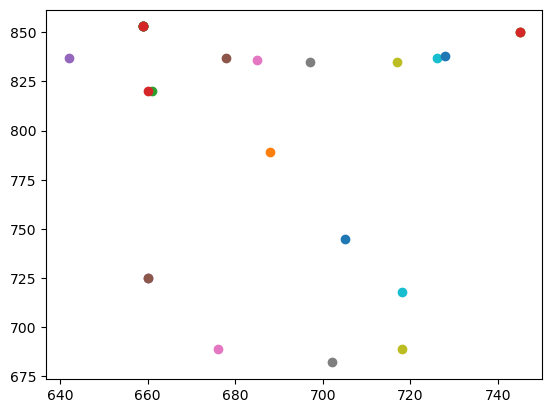



2sg2


KeyboardInterrupt: 

In [17]:
for name, group in df.groupby("digit")["pen_pos"]:
    print(name)
    for ci in group.to_list():
        plt.scatter(*ci)
    plt.show()
    print("\n")

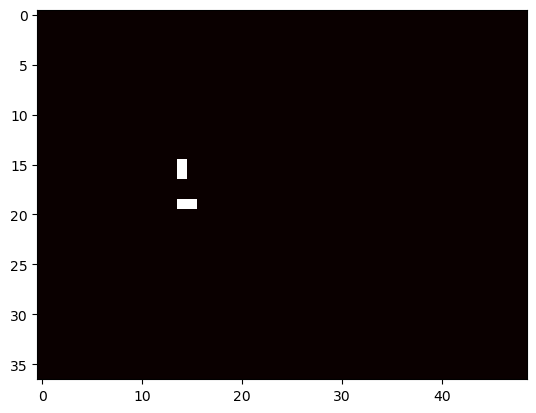

4


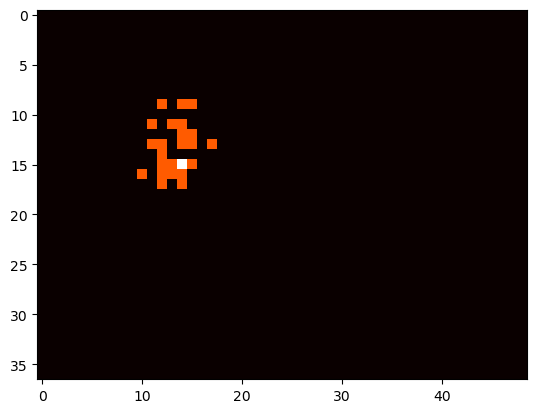

25


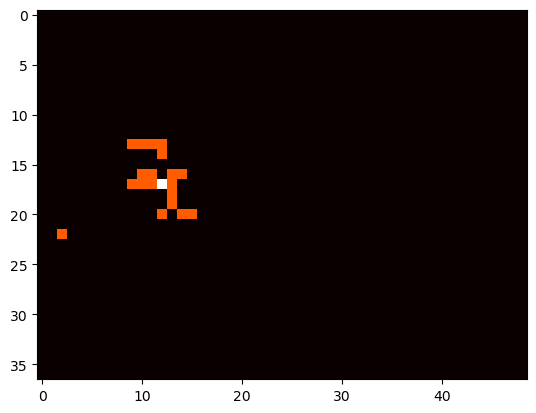

21


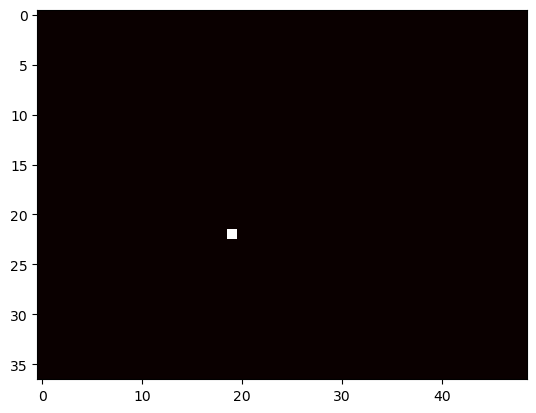

1


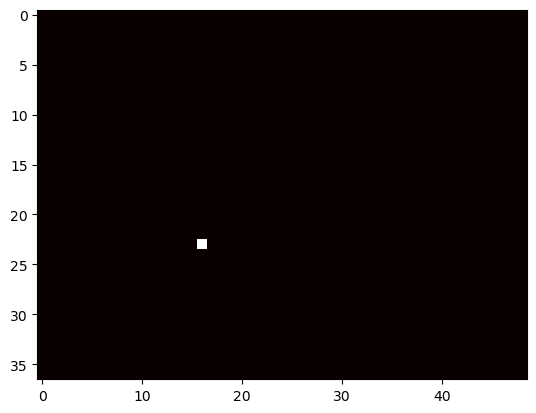

1


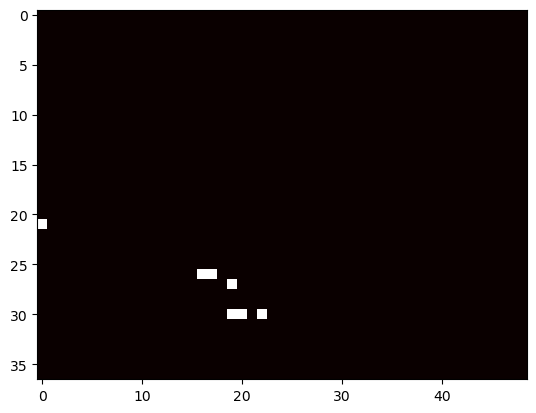

7


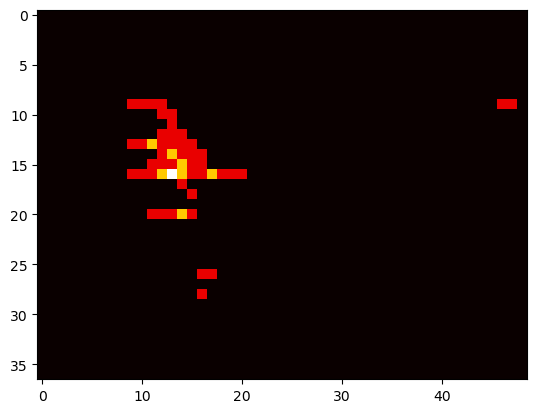

61


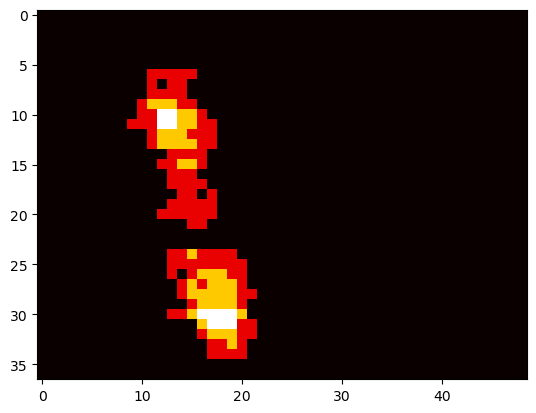

213


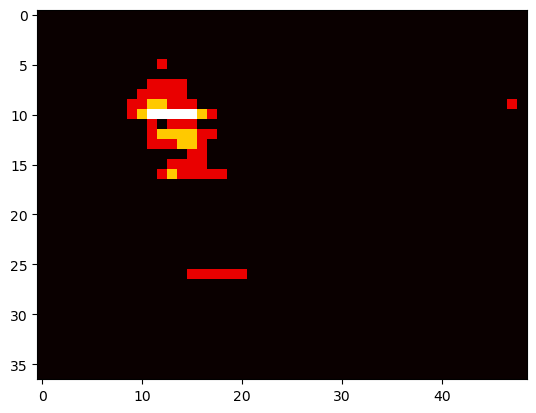

84


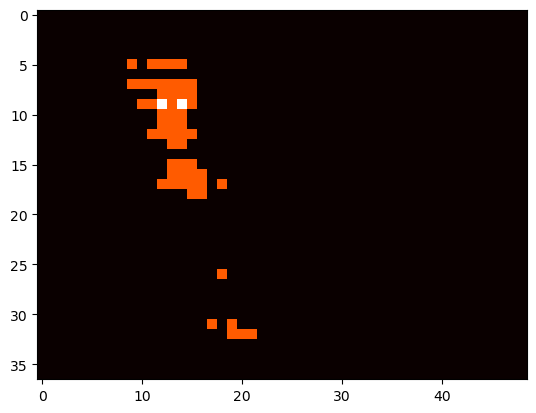

58


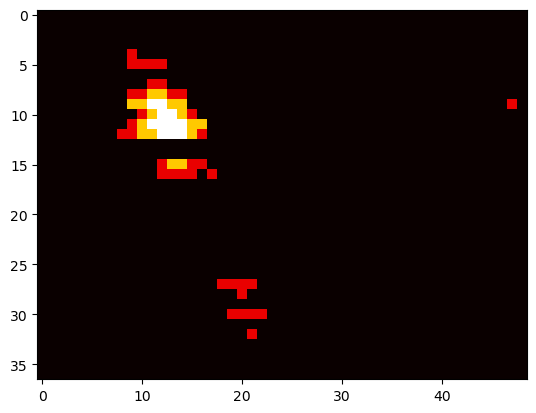

101


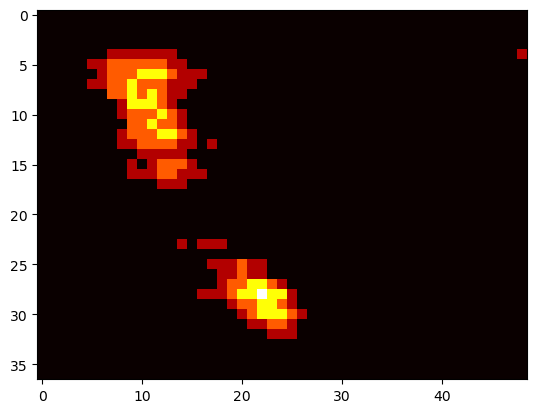

265


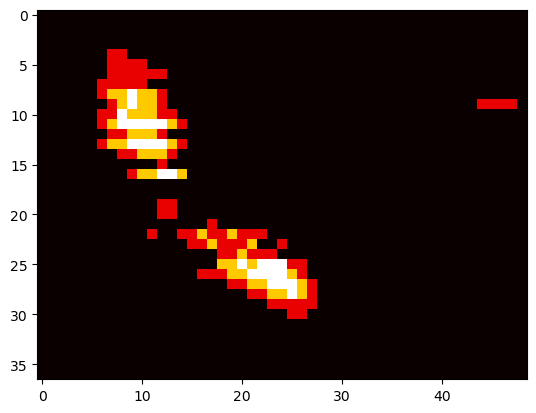

244


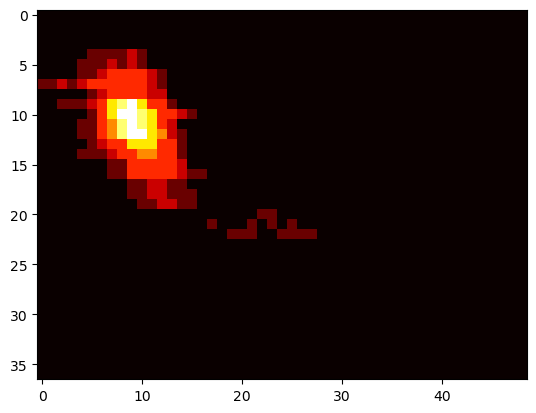

377


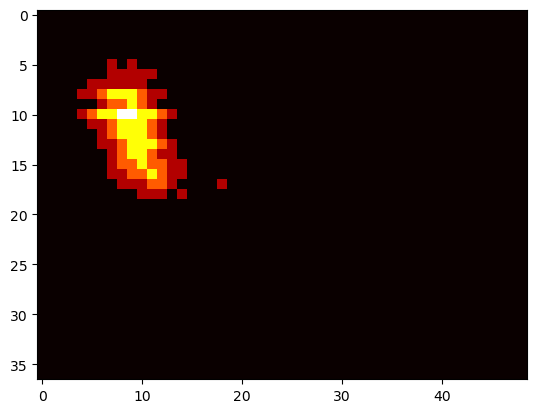

167


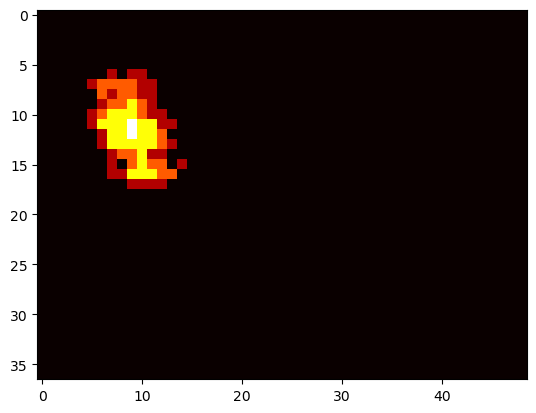

150


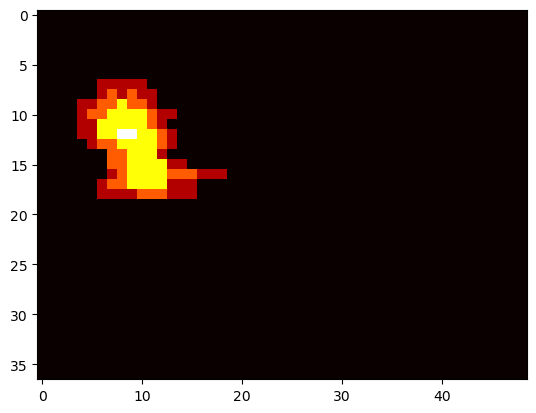

202


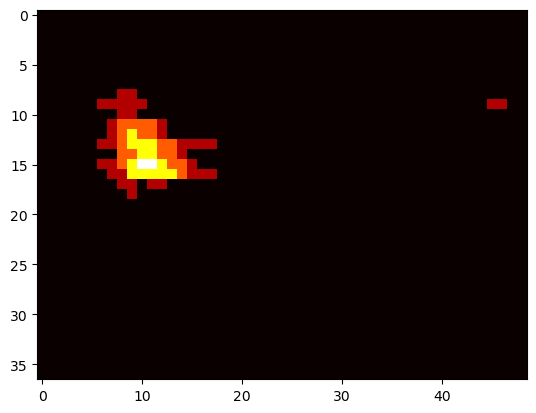

118


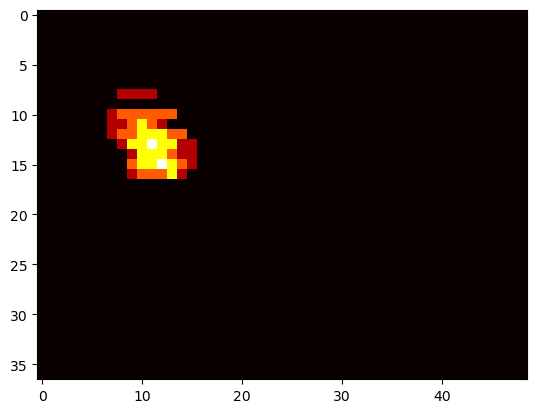

107


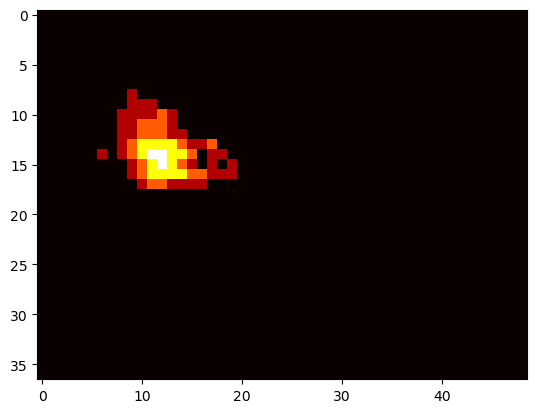

125


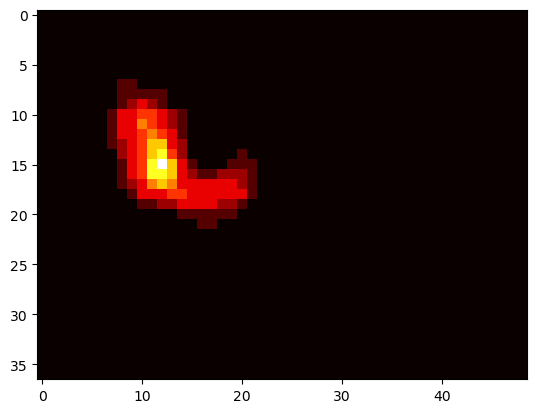

329


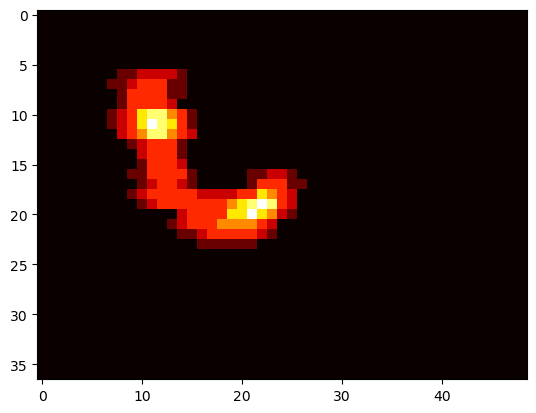

440


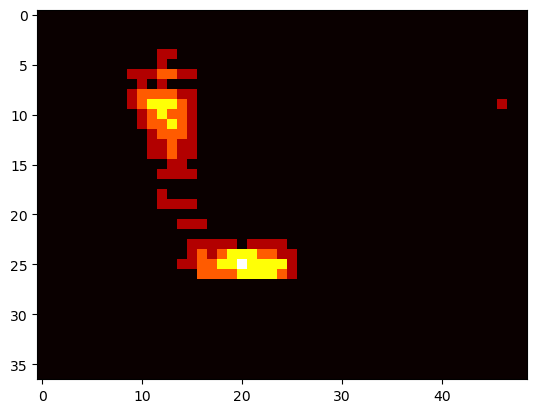

179


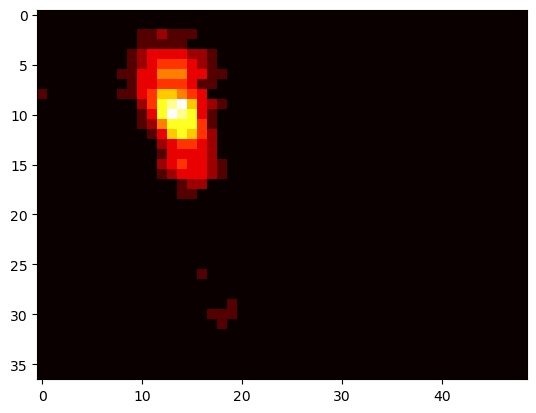

368


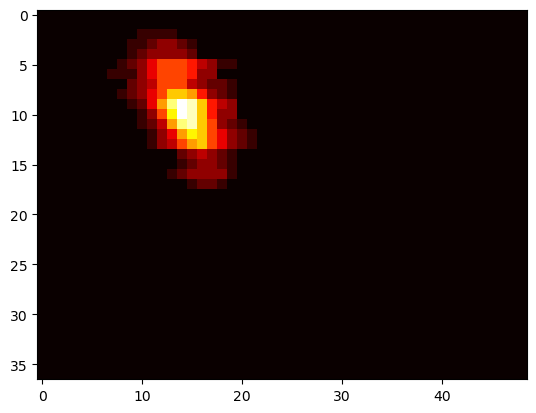

605


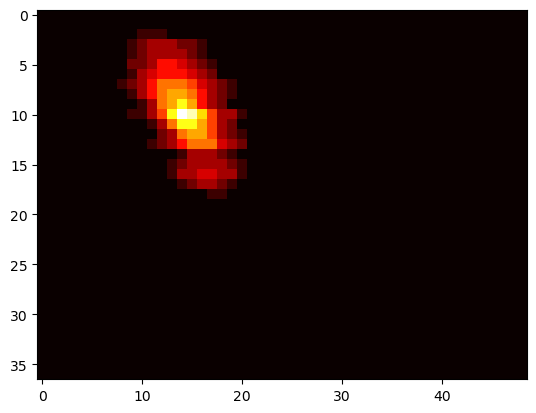

508


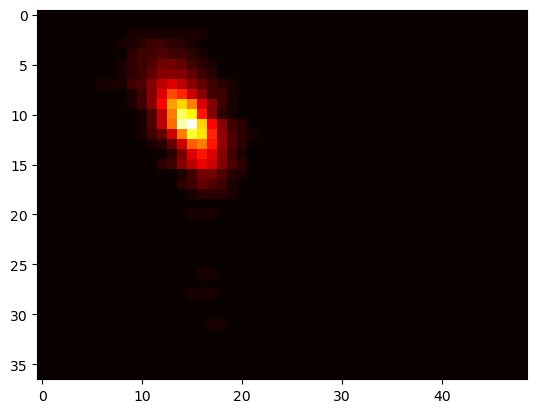

1060


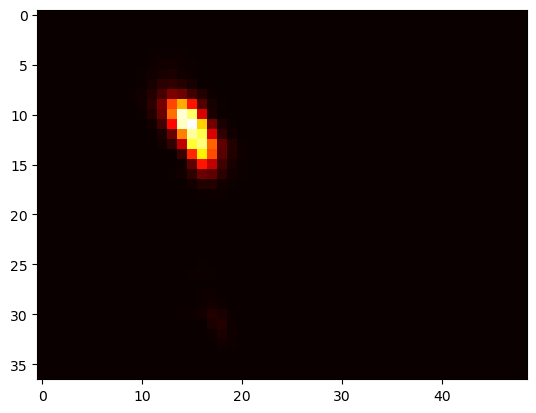

3594


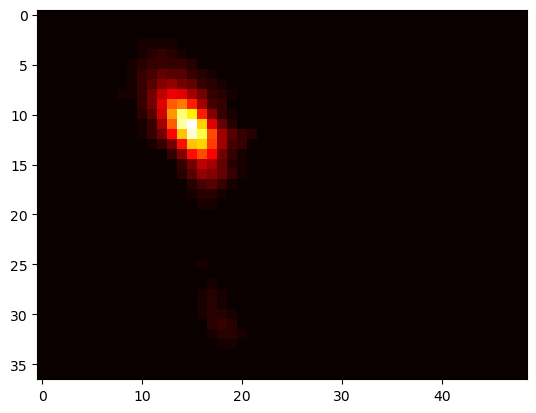

1108


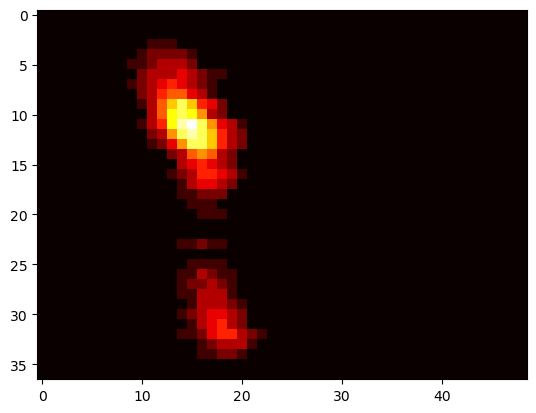

621


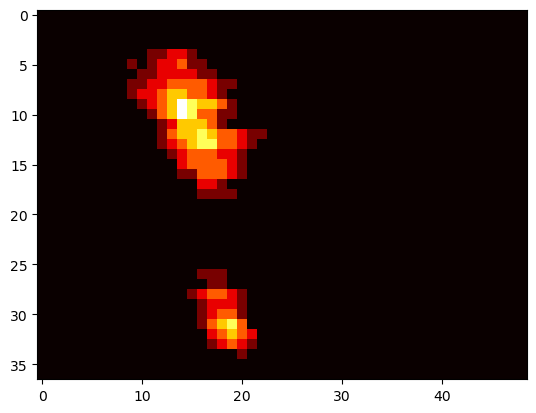

348


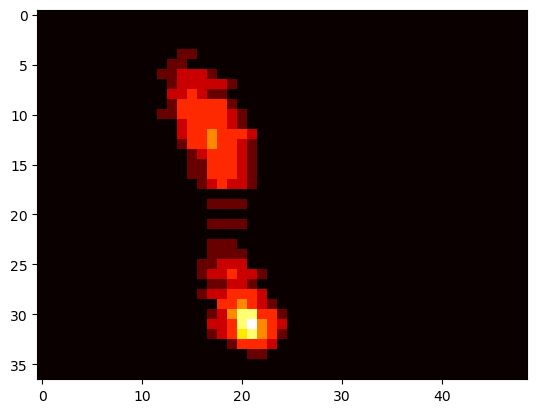

356


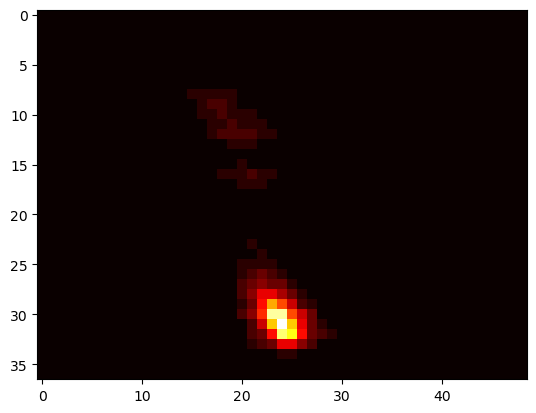

383


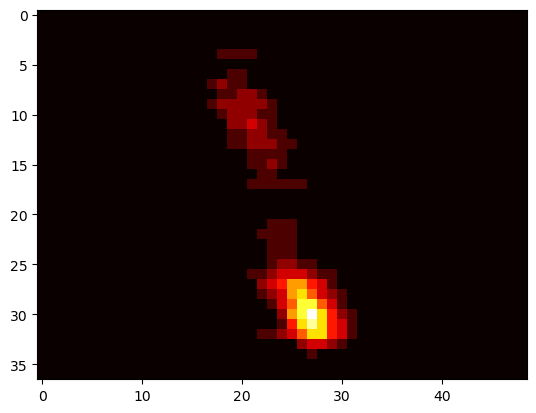

336


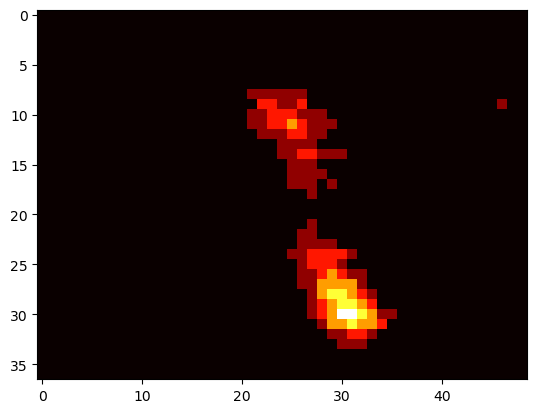

217


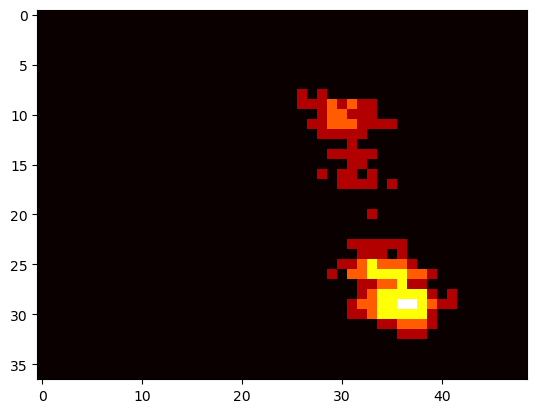

190


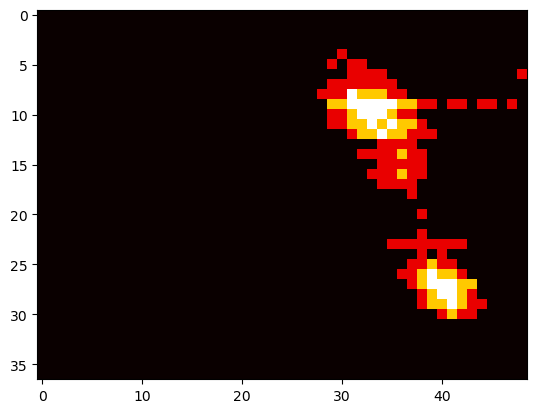

215


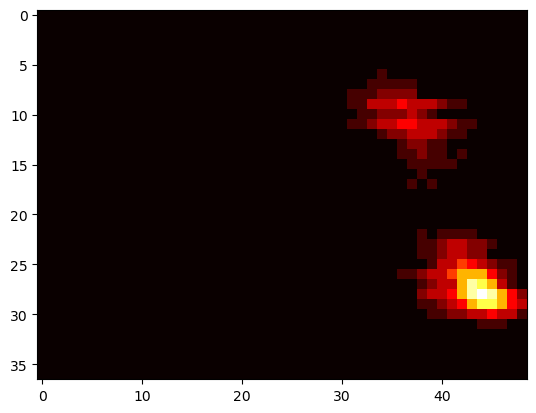

415


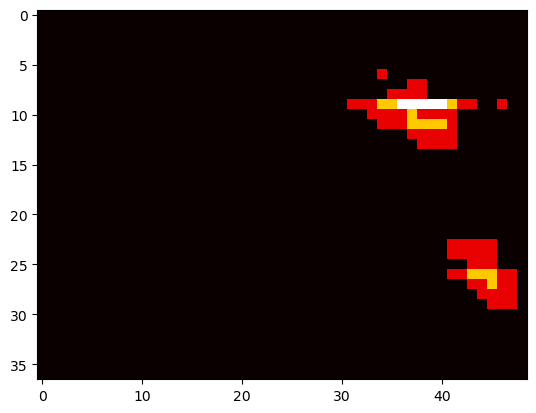

101


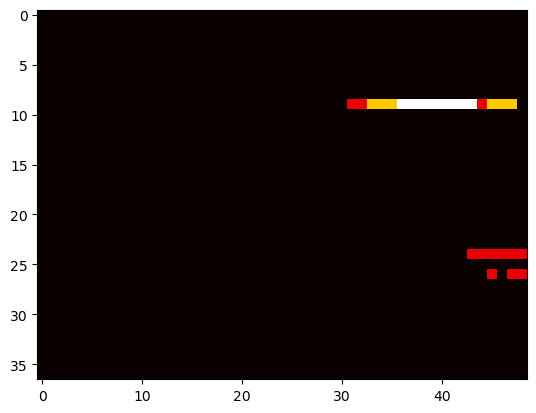

48


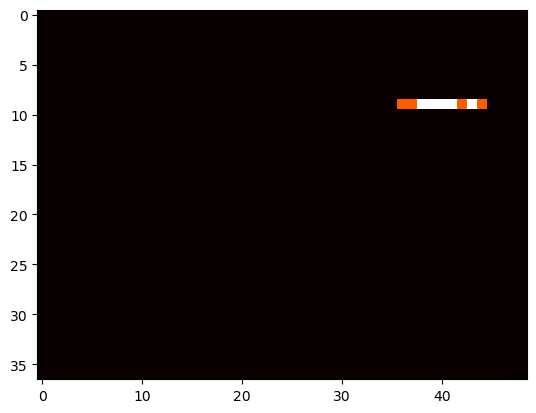

14


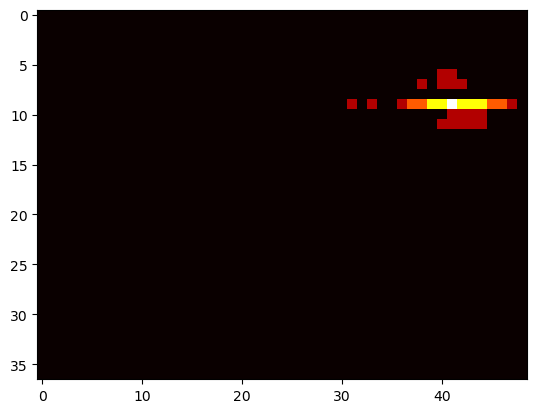

46


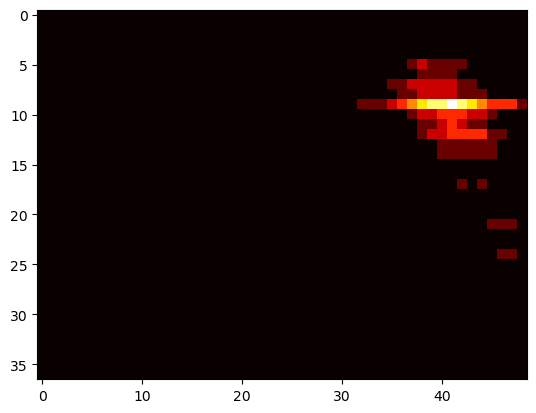

167


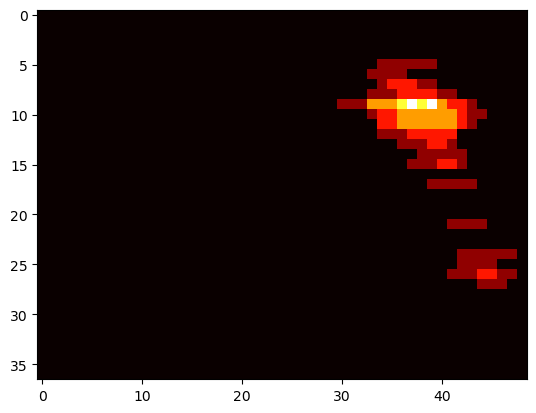

187


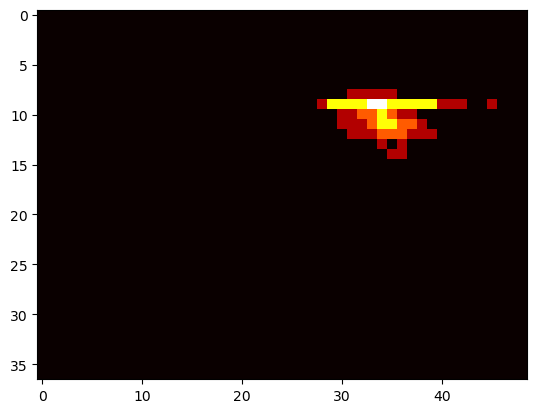

90


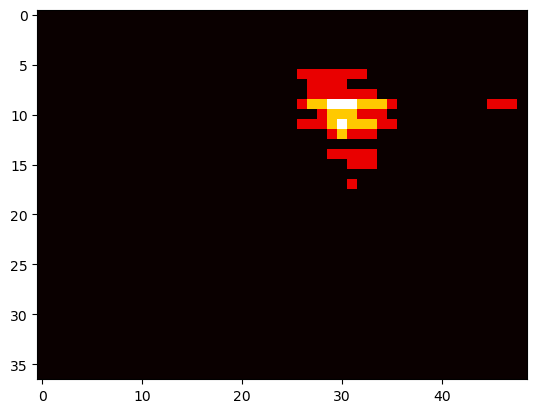

83


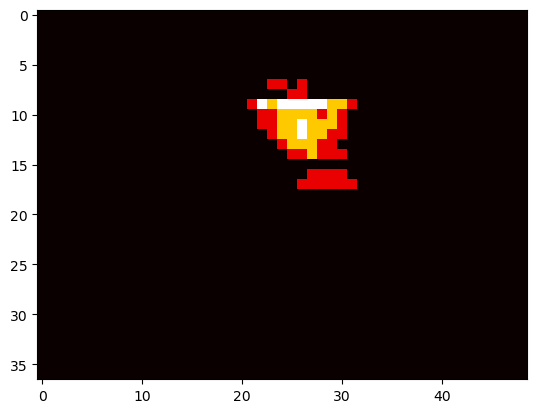

101


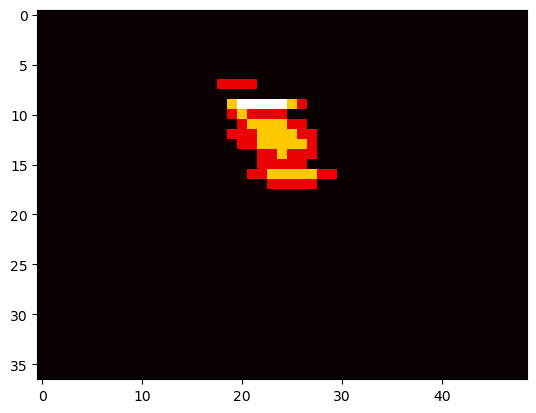

99


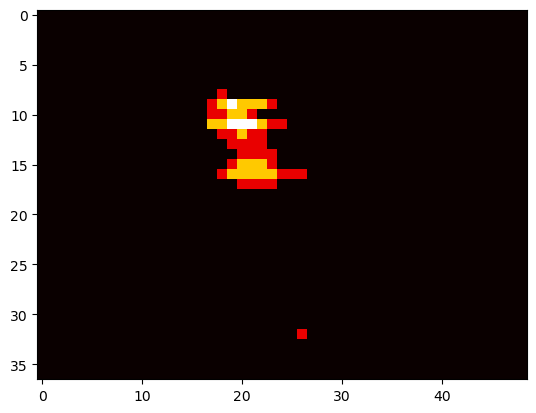

79


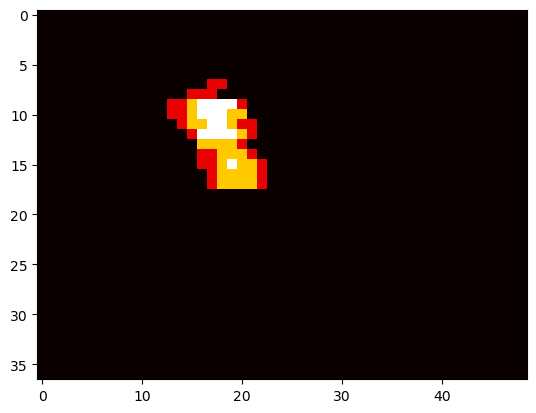

120


In [11]:
for i in range(len(prep_flat_cap_data[:50])):
    fr = prep_flat_cap_data[i][-1]
    display(fr)
    # print("\n")

In [20]:
def generate_video(img):
    for i in range(len(img)):
        plt.imshow(img[i], cmap='hot', interpolation='nearest')
        plt.savefig("video_imgs" + "/file%02d.png" % i)

    os.chdir("video_imgs")
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        'video_name.mp4'
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

In [21]:
def compute_img(cap_img):
    new_cap_img = [0] * 49 * 37
    for y in range(49):
        for x in range(37):
            val = cap_img[y * 37 + x]
            new_cap_img[(37 - x - 1) * 49 + y] = val
    cap_img_2d = np.reshape(new_cap_img, (37, 49))
    return cap_img_2d

In [22]:
imgs = []
for fcp in prep_flat_cap_data:
    imgs.append(compute_img(fcp[-1]))

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

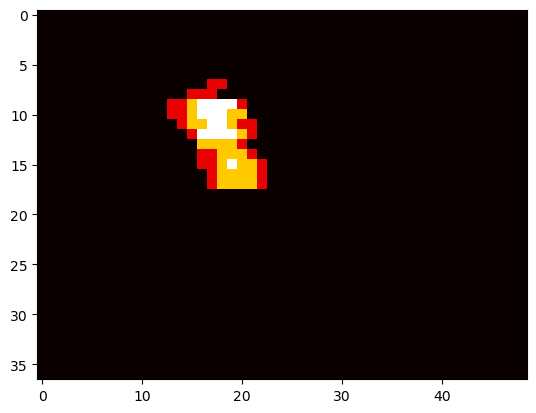

In [23]:
generate_video(imgs[:50])

## Baseline

In [213]:
def compute_img(cap_img):
    new_cap_img = [0] * 49 * 37
    for y in range(49):
        for x in range(37):
            val = cap_img[y * 37 + x]
            new_cap_img[(37 - x - 1) * 49 + y] = val
    cap_img_2d = np.reshape(new_cap_img, (37, 49))
    return cap_img_2d

In [202]:
def display(cap_img, pp_id):
    new_cap_img = [0] * 49 * 37
    for y in range(49):
        for x in range(37):
            val = cap_img[y * 37 + x]
            new_cap_img[(37 - x - 1) * 49 + y] = val
    cap_img_2d = np.reshape(new_cap_img, (37, 49))
    plt.imshow(cap_img_2d, cmap='hot', interpolation='nearest')
    com =  ndimage.center_of_mass(cap_img_2d)
    plt.scatter(com[1], com[0], c='green')
    pp = pps[pp_id]
    mm=41.65
    plt.scatter((2048-pp[1])/mm, pp[0]/mm, c='blue')
    plt.show()

In [178]:
pps = df[df.digit=="0mg0"]["pen_pos"].tolist()
pps

[[640, 768],
 [640, 768],
 [640, 768],
 [640, 768],
 [640, 768],
 [640, 768],
 [640, 768],
 [640, 768],
 [640, 768],
 [640, 768],
 [640, 768],
 [640, 768],
 [640, 768],
 [640, 768],
 [640, 768],
 [640, 768],
 [725, 597],
 [682, 597],
 [682, 597],
 [640, 597],
 [640, 619],
 [619, 640],
 [618, 640],
 [597, 659],
 [597, 682],
 [579, 725],
 [579, 725],
 [597, 746],
 [597, 768],
 [597, 790],
 [615, 810],
 [604, 859],
 [616, 876],
 [616, 877],
 [630, 915],
 [650, 918],
 [674, 920],
 [690, 920],
 [692, 920],
 [704, 920],
 [709, 906],
 [725, 895],
 [725, 895],
 [747, 871],
 [747, 871],
 [760, 846],
 [767, 848],
 [775, 804],
 [787, 791],
 [788, 786],
 [789, 747],
 [789, 725],
 [789, 725],
 [789, 725],
 [790, 703],
 [775, 675],
 [774, 675],
 [768, 640],
 [768, 640],
 [768, 618],
 [747, 597],
 [745, 597],
 [725, 597],
 [725, 597],
 [725, 597],
 [725, 597],
 [725, 597],
 [725, 597],
 [725, 597],
 [725, 597],
 [725, 597],
 [725, 597],
 [725, 597],
 [725, 597],
 [725, 597],
 [725, 597],
 [725, 597],

In [294]:
cap_img_1d = df[df.digit=="0mg0"]["cap_img"].tolist()

In [295]:
cap_img_2d = [compute_img(c) for c in cap_img_1d]

In [296]:
ci_2d_no_pen = cap_img_2d.copy()

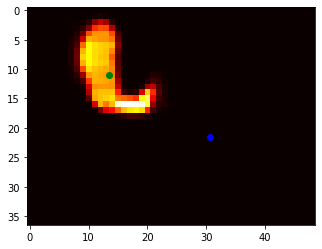

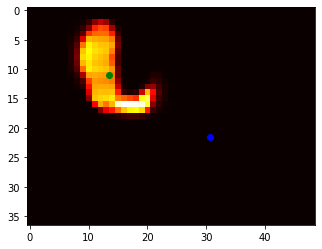

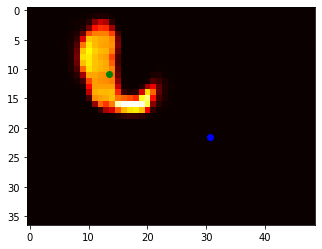

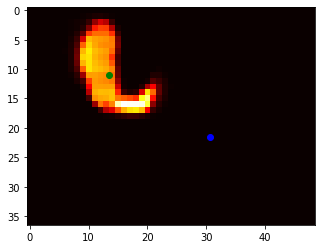

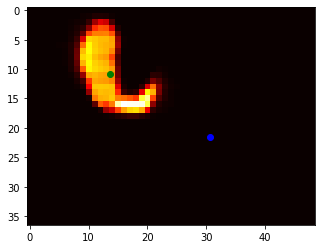

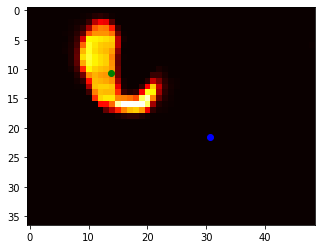

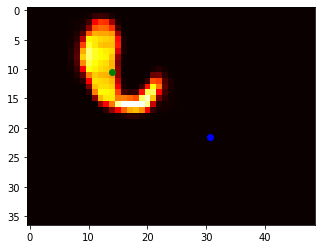

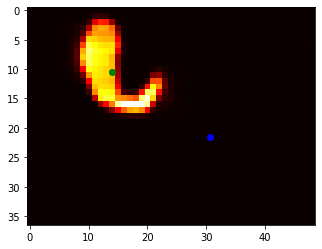

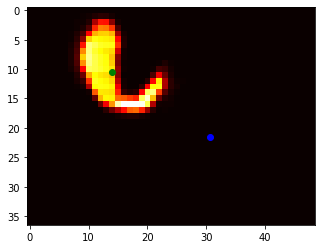

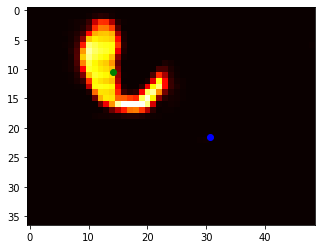

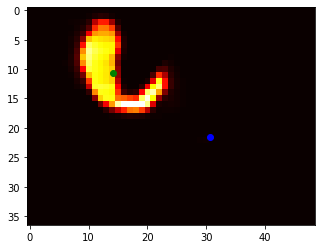

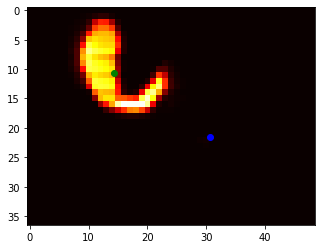

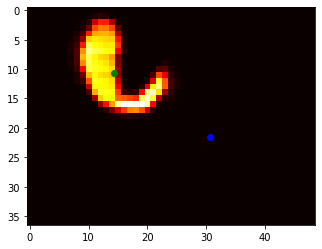

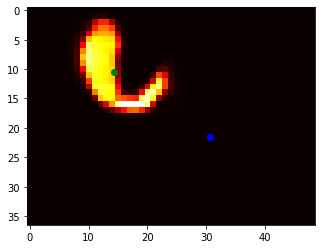

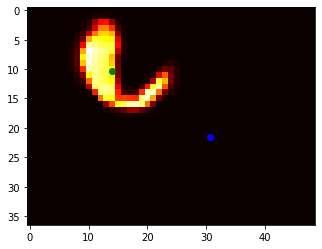

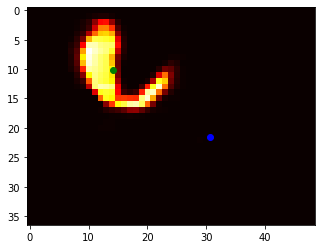

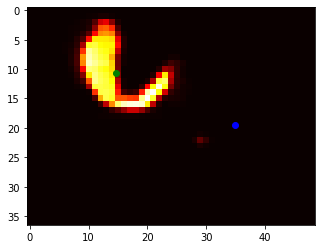

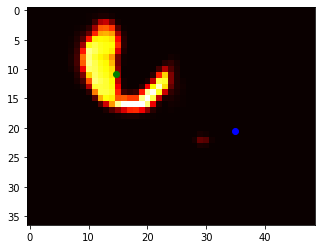

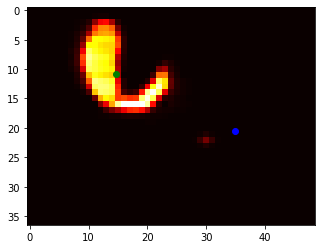

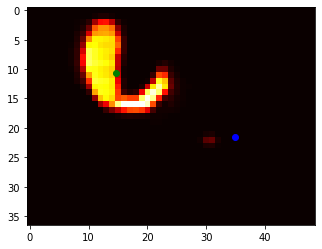

In [206]:
for i in range(len(cap_img_1d[0:20])):
    display(cap_img_1d[i], i)

In [297]:
coms = [ndimage.center_of_mass(c) for c in cap_img_2d]

In [276]:
def f7(seq):
    seen = set()
    return [x for x in seq if not (x in seen or seen.add(x))]

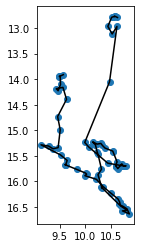

In [293]:
zero=f7([tuple(z) for z in coms])[:]
fig = plt.figure()
plt.scatter(x=[z[0] for z in zero], y=[z[1] for z in zero])
plt.plot([z[0] for z in zero], [z[1] for z in zero], "k")
ax = plt.gca()
ax.invert_yaxis()
ax.set_aspect('equal', adjustable='box')
# plt.show()
fig.canvas.draw()
